In [1]:
import pandas as pd

#load the excel file
test_data = pd.ExcelFile('./gorilla_test_data.xlsx') 


#extact list of the sheets in data frames
meter_list=test_data.parse('meter_list')
forecast_table=test_data.parse('forecast_table')
rate_table=test_data.parse('rate_table')


#Creation of a table for prices
RealPriceAQ=pd.merge(meter_list, rate_table, how="left", on="exit_zone")

#Creation of column to filter aq_kwh below category
RealPriceAQ['Filter_Qty1']=RealPriceAQ['aq_kwh']-RealPriceAQ['aq_min_kwh']

#Creation of column to filter aq_kwh above category
RealPriceAQ['Filter_Qty2']=RealPriceAQ['aq_kwh']-RealPriceAQ['aq_max_kwh']

#filter to keep only the prices of the right category
RealPriceAQ=RealPriceAQ[(RealPriceAQ['Filter_Qty2']<0)&(RealPriceAQ['Filter_Qty1']>=0)]

#remove filters (2 last columns) and rename 'date' for clarity
RealPriceAQ=RealPriceAQ.iloc[: , :-2]
RealPriceAQ=RealPriceAQ.rename(columns = {'date':'PricePeriod'})


#merge of the forecast_table with the prices for each meter_id with the given AQ
aggregate=pd.merge(forecast_table, RealPriceAQ, how="left", on="meter_id")


#filter to keep only the rows that are in the right PricePeriod
#remove all rows with a date before the PricePeriod
aggregate=aggregate[aggregate['date']>=aggregate['PricePeriod']]
#keep for each meter_id and given date the most recent price period
idx=aggregate.groupby(['meter_id','date'])['PricePeriod'].transform(max) == aggregate['PricePeriod']
aggregate=aggregate[idx]

#create the array for price per day for each day and each meter
aggregate['PricebyDay']=aggregate['kwh']*aggregate['rate_p_per_kwh']

#summarize for each meter the total production
sumProdbyMeter=(aggregate.groupby(['meter_id'])['kwh'].sum()).map('{:,.0f}'.format)


#Summarize for each meter the total cost
totalCostbyMeter=aggregate.groupby(['meter_id'])['PricebyDay'].sum()
totalCostbyMeter=(totalCostbyMeter/100).map('£{:,.2f}'.format)

#merge to generate output
output = pd.merge(sumProdbyMeter, totalCostbyMeter, how="left", on="meter_id")
output.rename(columns={'meter_id': 'Meter ID', 'kwh': 'Total Estimated Consumption (kWh)', 'PricebyDay':'Total Cost (£)'}, inplace=True)
display(output)

#I upgraded this version of the function for the benchmarking, see below

,Total Estimated Consumption (kWh),Total Cost (£)
meter_id,,
14676236,"28,978",£100.15
34509937,"78,324",£275.49
50264822,"265,667",£731.24
88357331,"484,399","£1,433.16"


In [2]:
def randomGenerator(nbrMeter):
#Generates a dataframe of meter_id, size of the meter and exit_zone
#takes as input nbrMeter, the number of meter we want to generate
#The meter_id is an increment from 0 to nbrMeter
#Size is generated randomly and exit zone is picked randomly in the list for each meter
    
    import numpy as np
    import pandas as pd
    
    #list of possible exit_zones
    exit_zone=['EA1', 'EA2', 'EA3', 'EA4', 'EM1', 'EM2', 'EM3', 'EM4', 'LC', 'LO', 'LS', 'LT', 'LW',
    'NE1', 'NE2', 'NE3', 'NO1', 'NO2', 'NT1', 'NT2', 'NT3', 'NW1', 'NW2', 'SC1', 'SC2',
    'SC4', 'SE1', 'SE2', 'SO1', 'SO2', 'SW1', 'SW2', 'SW3', 'WA1', 'WA2', 'WM1', 'WM2',
    'WM3']

    #pick randomly the exit_zone based on list index
    exit_zone_index=np.random.randint(low = 0,high=len(exit_zone),size=nbrMeter)
    exit_zone_list=[exit_zone[i] for i in exit_zone_index]
    
    #Generate the size of the meters
    size_list=np.random.randint(low = 1,high=1000000,size=nbrMeter)
    
    #attributes a incremental id_meter for each meter
    meter_id=range(nbrMeter)
    
    #create the dataframe for output
    rdnMeterList=pd.DataFrame({'meter_id':meter_id,'aq_kwh':size_list,'exit_zone':exit_zone_list})

    return(rdnMeterList)

randomGenerator(50000)

,meter_id,aq_kwh,exit_zone
0,0,883386,WM3
1,1,633339,LO
2,2,672962,NW2
3,3,16666,NW2
4,4,815918,SE1
...,...,...,...
49995,49995,168238,EA3
49996,49996,229442,LC
49997,49997,445865,EM2
49998,49998,639128,LC


In [3]:
def random_timeseries(list_meters, start_date, nbr_days):
    from datetime import datetime, timedelta
    import pandas as pd
    import numpy as np
    
    # Convert start date string to datetime object and calculate end date
    start_date = datetime.strptime(start_date, "%Y:%m:%d")
    end_date = start_date + timedelta(days=nbr_days)
    
    # Create date range with 1 hour frequency
    time_range = pd.date_range(start=start_date, end=end_date, freq='1H')
    
    # Generate random values for kwh between 0 and 1000 
    kwh = np.around(np.random.uniform(low = 0, high = 1000, size = len(time_range)), decimals = 4)
    
    # Create dataframe for each meter
    meter_ids = np.repeat(list_meters['meter_id'], len(time_range))
    rdn_timeseries = pd.DataFrame({'meter_id': meter_ids, 'date': np.tile(time_range, len(list_meters)), 'kwh': np.tile(kwh, len(list_meters))})
    
    return rdn_timeseries
random_timeseries(randomGenerator(500),'2020:04:1',500)

,meter_id,date,kwh
0,0,2020-04-01 00:00:00,889.1801
0,0,2020-04-01 01:00:00,859.0016
0,0,2020-04-01 02:00:00,241.2102
0,0,2020-04-01 03:00:00,304.0248
0,0,2020-04-01 04:00:00,364.4014
...,...,...,...
499,499,2021-08-13 20:00:00,635.1541
499,499,2021-08-13 21:00:00,84.2436
499,499,2021-08-13 22:00:00,920.5428
499,499,2021-08-13 23:00:00,737.2333


In [4]:
def transportRdnTable2(meter_list, forecast_table, rate_table):
    import pandas as pd
    import numpy as np

    #create a new dataframe with merged meter list and rate table

    real_price_aq = meter_list.merge(rate_table, how="left", on="exit_zone")

    # filter out prices that are not within the AQ range using numpy where function
    indexAQRange = real_price_aq[(real_price_aq['aq_kwh'] - real_price_aq['aq_min_kwh']  < 0) | (real_price_aq['aq_kwh'] - real_price_aq['aq_max_kwh'] >= 0) ].index
    real_price_aq.drop(indexAQRange, inplace=True)
    real_price_aq = real_price_aq.rename(columns={'date': 'PricePeriod'})

    # merge the forecast table and real price aq dataframe
    aggregate = forecast_table.merge(real_price_aq, how="left", on="meter_id")
    
    
    # filter out rows that are not in the right price period
    aggregate = aggregate[aggregate['date'] >= aggregate['PricePeriod']]
    #No need to sort : aggregate = aggregate.sort_values(by=['meter_id', 'date', 'PricePeriod'])
    aggregate = aggregate.drop_duplicates(subset=['meter_id', 'date'], keep='last')


    # calculate the price by day
    aggregate['PricebyDay'] = aggregate['kwh'] * aggregate['rate_p_per_kwh']

    # calculate total estimated consumption and total cost by meter
    sum_prod_by_meter = aggregate.groupby(['meter_id'])['kwh'].sum().map('{:,.0f}'.format)
    total_cost_by_meter = (aggregate.groupby(['meter_id'])['PricebyDay'].sum() / 100).map('£{:,.2f}'.format)

    # merge the two dataframes to get the final output
    output = sum_prod_by_meter.to_frame().merge(total_cost_by_meter.to_frame(), how="left", on="meter_id")
    return output


In [5]:
def launchTransport(nbrMeters, nbrDays):
    import pandas as pd
    
    #Function to start the computation of transportRdnTable2 by passing nbrMeters and nbrDays as parameters

    listMeterTest=randomGenerator(nbrMeters)

    forecastTest=random_timeseries(listMeterTest,'2020:04:1',nbrDays)


    test_data = pd.ExcelFile('./gorilla_test_data.xlsx') 
    rate_table=test_data.parse('rate_table')


    return transportRdnTable2(listMeterTest, forecastTest, rate_table)

launchTransport(100,100)


,kwh,PricebyDay
meter_id,,
0,"1,201,632","£3,451.09"
1,"1,201,632","£2,433.30"
2,"1,201,632","£3,044.94"
3,"1,201,632","£2,974.04"
4,"1,201,632","£2,499.39"
...,...,...
95,"1,201,632","£2,803.41"
96,"1,201,632","£2,322.75"
97,"1,201,632","£3,785.14"


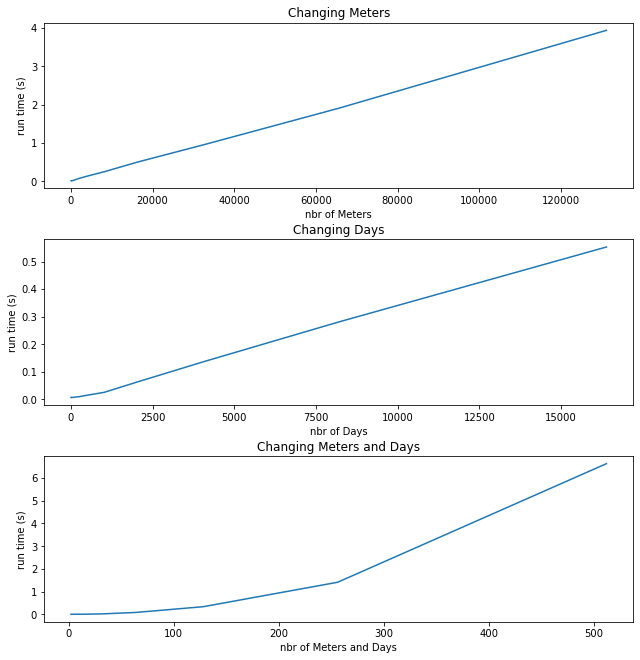

In [6]:
import timeit
import pandas as pd
import matplotlib.pyplot as plt
#Function to benchmark the transportRdnTable2 function and display the result graphically


#Load excel file and prepare arrays of results
test_data = pd.ExcelFile('./gorilla_test_data.xlsx') 
rate_table=test_data.parse('rate_table')
    
execTimeValueVarMeters=[]
execTimeValueVarDays=[]
execTimeValueVarDaysAndMeters=[]

    
    
#start runing transportRdnTable2 for 1 day and a growing numbers of Meters, stores the compute time in an array
for i in [2 ** k for k in range(1,18)]:
    listMeterTest=randomGenerator(i)
    forecastTest=random_timeseries(listMeterTest,'2020:04:1',1)
    
    execTimeValueVarMeters.append(timeit.timeit(lambda : transportRdnTable2(listMeterTest, forecastTest, rate_table), number=1))
    
    

#start runing transportRdnTable2 for 1 meter and a growing numbers of days, stores the compute time in an array
for i in [2 ** k for k in range(1,15)]:
    listMeterTest=randomGenerator(1)
    forecastTest=random_timeseries(listMeterTest,'2020:04:1',i)

    execTimeValueVarDays.append(timeit.timeit(lambda : transportRdnTable2(listMeterTest, forecastTest, rate_table), number=1))

    

#start runing transportRdnTable2 for a growing numbers of Meters and days, stores the compute time in an array
for i in [2 ** k for k in range(1,10)]:
    listMeterTest=randomGenerator(i)
    forecastTest=random_timeseries(listMeterTest,'2020:04:1',i)

    execTimeValueVarDaysAndMeters.append(timeit.timeit(lambda : transportRdnTable2(listMeterTest, forecastTest, rate_table), number=1))
    
    
fig, ax = plt.subplots(3,1, figsize=(10, 10))
fig.tight_layout(pad=5, w_pad=5, h_pad=3)
 
# set data with subplots and plot
ax[0].plot([2 ** k for k in range(1,len(execTimeValueVarMeters)+1)],execTimeValueVarMeters, label="Meters")
ax[0].title.set_text('Changing Meters')
ax[0].set(xlabel='nbr of Meters', ylabel='run time (s)')

ax[1].plot([2 ** k for k in range(1,len(execTimeValueVarDays)+1)],execTimeValueVarDays, label="Days")
ax[1].title.set_text('Changing Days')
ax[1].set(xlabel='nbr of Days', ylabel='run time (s)')

ax[2].plot([2 ** k for k in range(1,len(execTimeValueVarDaysAndMeters)+1)],execTimeValueVarDaysAndMeters, label="Days*Meters")
ax[2].title.set_text('Changing Meters and Days')
ax[2].set(xlabel='nbr of Meters and Days', ylabel='run time (s)')

plt.show()


We might have to handle data coming from millions of Meters over extensive time frames.
Therefore it's important that this code can scale efficiently with large sets of data.

The complexity of the algorithm is in O(m*n) due to the merge functions. To be more efficient, we should find a way to avoid merging big arrays.

We are merging the Forecast table with the price table, creating 10 lines (we have the price of 10 periods of time per exit_zone) for each line of the first table. It would be more efficient to use chunks of the price table for a given time period.

We could use other libraries than pandas. The use of Dask or PySpark libraries is common for big data handling. The use of optimized data structures like PyTables to store the data also provides much faster data access compared to Pandas dataframes.

The use of parallel processing can also improve the speed of computation if we can distribute the load.